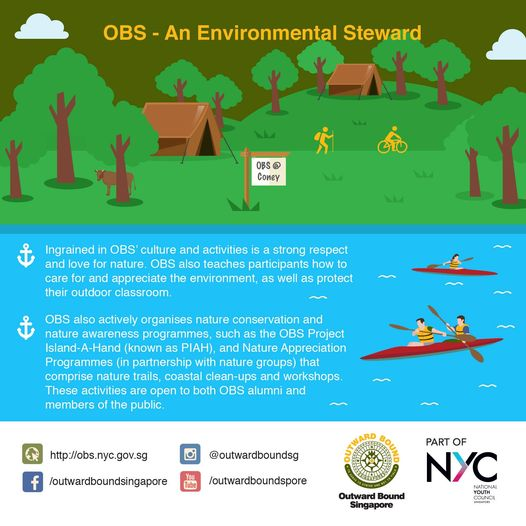

In [7]:
from IPython.display import Image, display, Audio, Markdown
import base64

IMAGE_PATH = "../../data/OBS.jpg"

# Preview image for context
display(Image(IMAGE_PATH))

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

In [44]:
from openai import AzureOpenAI
client = AzureOpenAI(
    api_key = "sk-BiSgwLrRSQinyLFKoB86Ug",  
    api_version = "2023-12-01-preview",
    azure_endpoint = "https://litellm.launchpad.tech.gov.sg"
)


messages=[
    {"role": "system", "content": "You are a helpful assistant that responds in Markdown."},
    {"role": "user", "content": [
        {"type": "text", "text": "Extract all the text in the image."},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]
response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    temperature=0.0,
)
response

ChatCompletion(id='chatcmpl-9eMXnO9sNpDlVLMKNbHtYqBSI2YCq', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="**OBS - An Environmental Steward**\n\nIngrained in OBS' culture and activities is a strong respect and love for nature. OBS also teaches participants how to care for and appreciate the environment, as well as protect their outdoor classroom.\n\nOBS also actively organises nature conservation and nature awareness programmes, such as the OBS Project Island-A-Hand (known as PIAH), and Nature Appreciation Programmes (in partnership with nature groups) that comprise nature trails, coastal clean-ups and workshops. These activities are open to both OBS alumni and members of the public.\n\n- [http://obs.nyc.gov.sg](http://obs.nyc.gov.sg)\n- @outwardboundsg\n- /outwardboundsingapore\n\n**Outward Bound Singapore**\n\n**PART OF NYC**\n**National Youth Council**", role='assistant', function_call=None, tool_calls=None))], created=1719406807

In [15]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "../../data/brewbytes.mkv"



In [17]:
import os
def process_video(video_path, seconds_per_frame=None):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    if seconds_per_frame == None:
        seconds_per_frame = total_frames//10
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
        
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

MoviePy - Writing audio in ../../data/brewbytes.mp3


MoviePy - Done.
Extracted 86 frames
Extracted audio to ../../data/brewbytes.mp3


In [ ]:
"""
# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)

## OPTIONAL: Uncomment the line below to print the transcription
#print("Transcript: ", transcription.text + "\n\n")

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
    {"role": "user", "content": [
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)
"""

In [ ]:
def decode_base64_frame(base64_str):
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    return image

In [37]:
import base64
from PIL import Image
from io import BytesIO
import torch
from torchvision import models, transforms
from transformers import ViTModel, ViTFeatureExtractor
import numpy as np

# Define the decode function
def decode_base64_frame(base64_str):
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    return image

# Define the preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image):
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Load pre-trained models
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove the classification layer
resnet.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the feature extraction function
def extract_features(image_tensor):
    with torch.no_grad():
        features = resnet(image_tensor)
    return features.squeeze()  # Remove batch dimension

# Define the embedding function
def embed_features(image):
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = vit_model(**inputs)
    embeddings = outputs.last_hidden_state  # or pooler_output for pooled embeddings
    return embeddings
video_embeddings = []
for base64_frame in base64Frames:
    image = decode_base64_frame(base64_frame)
    preprocessed_image = preprocess_image(image)

    embeddings = embed_features(image)
    video_embeddings.append(embeddings.reshape(-1).detach().numpy())
video_embeddings = np.array(video_embeddings)
print(video_embeddings.shape)

(86, 151296)


In [40]:
from sklearn.cluster import KMeans
kmeans =  KMeans(n_clusters=10, random_state=42)
kmeans.fit(video_embeddings)
kmeans.cluster_centers_

array([[-0.38436344,  0.04688919, -0.31670633, ..., -0.11814861,
         0.0251293 , -0.33749846],
       [-0.36177194,  0.01193214, -0.28095916, ..., -0.09459432,
         0.03785853, -0.30579695],
       [-0.3108436 ,  0.04901451, -0.2152487 , ..., -0.11612406,
         0.03417854, -0.26847935],
       ...,
       [-0.34837717,  0.05142358, -0.2580708 , ..., -0.11031842,
         0.00487567, -0.35551453],
       [-0.37405002,  0.04568003, -0.31235537, ..., -0.0808958 ,
         0.06020159, -0.3027865 ],
       [-0.35715127,  0.04826184, -0.34116563, ..., -0.05729324,
         0.00657284, -0.3315989 ]], dtype=float32)

In [43]:
# Compute distances from each point to each cluster center
cluster_centers = kmeans.cluster_centers_
distances = np.linalg.norm(video_embeddings[:, np.newaxis] - cluster_centers, axis=2)

# Find the index of the closest point to each cluster center
closest_indices = np.argmin(distances, axis=0)
len([base64Frames[idx] for idx in closest_indices])

10

In [32]:
from transformers import pipeline
import soundfile as sf
from pydub import AudioSegment

pipe = pipeline("automatic-speech-recognition", model="openai/whisper-small")
transcription = pipe("../../data/brewbytes.wav")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


FileNotFoundError: [WinError 2] The system cannot find the file specified